<img src="PolyMTL_Logo.JPG" alt="Drawing" style="width: 400px; height: 300px"/>

# INF8215 - Intelligence artif.: méthodes et algorithmes
## TP3
##### Equipe MMA - Manu Serpette 2229693 - Marc-Antoine Bettez 1828113 - Allen Yu 1958185


---
## Feature design



- Choix des attributs

> <p style="text-align:justify;">Afin de choisir quels attributs du dataset sont pertinent pour la detection d'url de phishing, nous avons calculer la matrice de corrélation des attributs du set</p>

> <p style="text-align:justify;">De plus afin de favoriser la précision du modèle nous avons, après avoir éliminé les attributs non numérique, normalisé entre 0 et 1 les attributs restants, ce qui permet d'éviter les biais où une feature domine le les autres.</p>

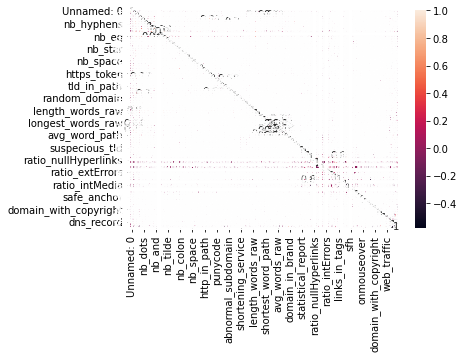

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
df2 = pd.read_csv("train.csv", header=0)
corr_matrix = df2.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

def filter(L):
    res = []
    for i in L:
        if i > 0.5:
            res.append(1)
        else:
            res.append(0)
    return res


def compute_accuracy(Y_true, Y_pred):
    correctly_predicted = 0
    # iterating over every label and checking it with the true sample
    for true_label, predicted in zip(Y_true, Y_pred):
        if true_label == predicted:
            correctly_predicted += 1
    # computing the accuracy score
    accuracy_score = correctly_predicted / len(Y_true)
    return accuracy_score


- <p style="text-align:justify;">A l'aide de la matrice de corrélation ci dessus et de ce qu'il nous semblait pertinent au regard de la detection de phishing, nous avons sélectionné certaines features du dataset. Dans la matrice de corrélation nous avons enlevé les features qui ont une correlation très faible avec les autres features.</p>

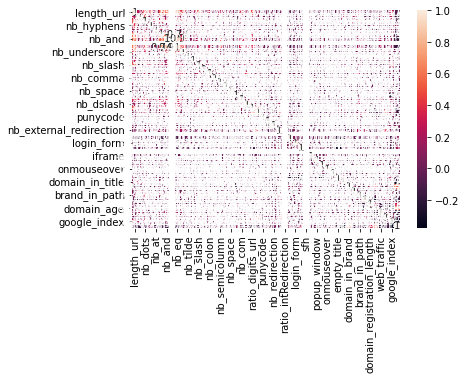

In [50]:
def build_set(path):
    df = pd.read_csv(path, header=0)
    selected_columns = ['length_url', 'length_hostname', "nb_dots", "nb_hyphens", "nb_at", "nb_qm", "nb_and", "nb_or",
                        "nb_eq", "nb_underscore", "nb_tilde", "nb_percent", "nb_slash", "nb_star", "nb_colon",
                        "nb_comma", "nb_semicolumn", "nb_dollar", "nb_space", "nb_www", "nb_com", "nb_dslash",
                        "ratio_digits_url", "ratio_digits_host", "punycode", "path_extension", "nb_redirection",
                        "nb_external_redirection",
                        "ratio_intRedirection", "ratio_extRedirection", "login_form", "external_favicon", "sfh",
                        "iframe", "popup_window", "safe_anchor", "onmouseover", "right_clic", "empty_title",
                        "domain_in_title", "domain_in_brand", "brand_in_subdomain", "brand_in_path",
                        "whois_registered_domain", "domain_registration_length", "domain_age", "web_traffic",
                        "dns_record", "google_index", "page_rank"]
    x = df[selected_columns]
    x = df._get_numeric_data()
    x = x.drop(columns=['Unnamed: 0'])
    x = x.to_numpy()
    x = normalize(x, axis=0)
    y = df["status"].map({'legitimate': 0, 'phishing': 1})
    corr_matrix = df2[selected_columns].corr()
    sns.heatmap(corr_matrix, annot=True)
    plt.show()
    return x, y

# Define Grid
x_train, y_train = build_set("train.csv")
x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.3, shuffle=True)



- <p style="text-align:justify;">Sur la nouvelle matrice de corrélation ci dessus ont voit que globalement nos features sont en moyenne plus corrélés aux autres que sur la première matrice. Notre choix de features est donc pertinent mais pourrait avec plus de temps être amélioré pour maximiser la cross corrélation. Par exemple utiliser une analyse en composantes principales pourrait permettre d'extraire un nouveau set de features minimal maximisant la pertinence de ces dernières.</p>

## Méthodologie

- Répartition des données

> <p style="text-align:justify;">Nous avons réalisé un split avec 70% des données pour l'entrainement et 30% pour tester le modèle, ce split permet de detecter un overfit du modèle</p>

> <p style="text-align:justify;">Le dataset contient 4629 url legitime et 3543 url compromises, on peut dire que le dataset est plustot équilibré, nous avons donc choisi de ne pas reéquilibré ce dernier.</p>

- Choix du modèle

> <p style="text-align:justify;">Après lecture d'un article, [1].  Nous avons choisi d'utiliser un random forest classifieur, étant un modèle délivrant le plus de résultats pour ce genre d'exercice. Et ce notamment, étant basé sur plusieurs arbres de décision, grace à leurs haute précision, faible biais et capacité de scaling sur de grands datasets.</p>



- Tuning des hyperparamètres


<p style="text-align:justify;">Afin de déterminer les hyperparamètre optimaux nous effectuons un gridSearch sur les paramètres suivant:</p>

        - Le nombre d'estimateurs, représentant les multiple arbres de décision de la forêt 
        - La fonction pour le calcul du nombre de features à regarder
        - La profondeur de l'arbre

<p style="text-align:justify;">Nous utilisons gridSearch sur la précision car cela vas nous permettre de maximiser les hyper paramètres de notre modèle et facilement reconstruire notre modèle une fois ces paramètres trouvés.</p>
<p style="text-align:justify;">Nous spécifions des intervalles pour chaques paramètres, si le résultat du GridSearch tombe sur une borne nous étendons l'intervalle et ainsi de suite.</p>

In [51]:
grid = {
    'n_estimators': [400,500,600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400],
    'max_features': ['sqrt','log2'],
    'max_depth': [16, 18, 20, 24, 28, 30, 32],
    'random_state': [18]
}

In [52]:
CV_rfr = GridSearchCV(estimator=RandomForestClassifier(),
                      param_grid=grid, cv=5, verbose=10, n_jobs=-1)
CV_rfr.fit(x_train, y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [16, 18, 20, 24, 28, 30, 32],
                         'max_features': ['sqrt'],
                         'n_estimators': [600, 800, 1000, 1200, 1400, 1600,
                                          1800, 2000, 2200, 2400],
                         'random_state': [18]},
             verbose=10)

Les hyper paramètres optimaux trouvés par le grid search sont les suivants:

In [53]:
print("\n The best parameters across ALL searched params:\n", CV_rfr.best_params_)


 The best parameters across ALL searched params:
 {'max_depth': 24, 'max_features': 'sqrt', 'n_estimators': 600, 'random_state': 18}


- <p style="text-align:justify;">On remarque que le gridSearch nous propose une profondeur de 24. Cela représente un arbre plutôt profond et on pourrait s'attendre à de l'overfitting malgré la grande précision obtenue sur le jeu d'entrainement (0.97). Cependant le nombre d'estimateurs proposé est de 600, ce qui est important. Ce nombre d'arbres de décision élevé va augmenter considérablement le temps d'entrainement mais réduire l'overfitting, ont peut donc espérer que les deux effets vont se composer et que notre modèle sera de grande précision sur le jeu de test.</p>


- <p style="text-align:justify;">On peut maintenant demander au modèle utilisant les paramètres precèdents de réaliser une prédiction sur le jeux de test pour obtenir la précision du modéle et la matrice de confusion associée à ce jeu de données.</p>

In [54]:
prediction = filter(CV_rfr.predict(x_test))

In [55]:
print("Accuracy: ", compute_accuracy(y_test, prediction))

Accuracy:  0.9645187601957586


- <p style="text-align:justify;">Nous obtenons sur le dataset de test une précision très elevée et proche de la précision d'entrainement, nous pouvons donc conclure que notre modèle est pertinent et qu'il overfit très peu.</p>

## Résultats

- Matrice de confusion:

La matrice de confusion vas nous donner le nombre de faux positif et de faux négatif du modèle:

In [56]:
#code matrice de confusion
print(confusion_matrix(filter(y_test), prediction))

[[1340   45]
 [  42 1025]]


- <p style="text-align:justify;">On remarque que sur plus de 2300 urls testées seulement 87 urls ont été mal classifiées. On peut donc considèrer que le filtre est utilisable en pratique car il protégera l'utilisateur contre une grande majorité des menaces.</p>

### Analyse des résultats de la matrice de confusion

- <p style="text-align:justify;">Afin d'analyser en détails notre modèle nous construisons un graphique représentant la précision de l'arbre en fonction des paramètres du gridSearch</p>

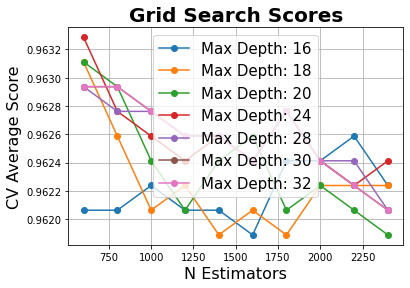

In [57]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2), len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2), len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1, 1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx, :], '-o', label=name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    plt.show()
plot_grid_search(CV_rfr.cv_results_, grid['n_estimators'], grid['max_depth'], 'N Estimators', 'Max Depth')

<p style="text-align:justify;">Ce graph illustre bien le choix de paramètre du gridSearch. On remarque en effet qu'il a bien choisi le couple permettant de maximiser la métrique, qui ici est la précision ( Nous avons choisi la même métrique que sur Kaggle ).</p>

## Résultat sur Kaggle

<p style="text-align:justify;">Après avoir envoyé notre prédiction sur Kaggle nous obtenons une précision de 0.95 soit 0.01 en dessous de ce que nous avion sur notre machine. Cela est assez rassurant car cela veut dire que notre modèle à peu d'overfitting. Le résultat est 0.04 au dessus de la baseline, nous sommes donc satisfait par ce modèle.</p>

## Discussion

<p style="text-align:justify;"> Pour conclure sur les méthodes utilisés, après experimentation, nous avons vu une légére amélioration des résultats en utilisant la normalisation et le choix de features.</p>

<p style="text-align:justify;"> L'utilisation de GridSearch est quand à elle fidèle à sa promesse est délivre bien le meilleurs choix de paramètres possible parmis ceux qui lui sont fournis. Un défaut de cette méthode serait son temps d'exécution qui explose combinatoirement avec le nombre de paramètres passés.</p>

<p style="text-align:justify;"> Pour améliorer nos résultats il serait intéressant d'affiner le choix de features, par exemple en maximisant la corrélation moyenne de la matrice post séléction ou encore en utilisant une ACP pour générer des features plus pertinentes. Il serait évidemment intéressant de tester d'autre modèles, comme par exemple le ADAboost, XGboost, la régression logistique ou même des réseaux de neurone.


## Références

[[1]Shahrivari, Vahid & Darabi, Mohammad & Izadi, Mohammad. (2020). Phishing Detection Using Machine Learning Techniques.](https://arxiv.org/pdf/2009.11116.pdf)